Use the button below to see raw code in the analysis, otherwise read ahead!

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="View raw code"></form>''')

# Historical Air Temperature & Snow Density Analysis, Part II

## *Completed for*: Bridger Teton Avalanche Center  

## Patrick Wright, Inversion Labs

## March 1 2016


**CONTENTS:**

**1. Introduction**

**2. Summary and conclusions**

**3. 3D plots with best-fit planes**

**4. Equations**

**5. Wind vs. density**

# 1. Introduction

In this analysis, wind has been added as a 2nd predictor variable, and best-fit planes are used to model the data in 3-dimensional space. Analysis has been extended to Rendezvous Bowl and Raymer plots in addition to the Mid Mtn plot. The date range has been constrained to Dec. 15 - March 30. Although not detailed in this report, attempts were made to exclude snow totals <2" and <3", however there was no significant improvement to the fit, reductions of outliers, or major changes to the overall shape of the best-fit planes, therefore the previous threshold of 1" snow totals was retained.

# 2. Summary and Conclusions

These results are used to define equations for the snow density calculator located at:
    
http://www.inversionlabs.com/pages/density.html

The following data is currently used for each station:
    
**Mid Mtn:**
* Mid Mtn previous 24-hr mean air temp
* Summit previous 24-hr total wind miles
* Mid Mtn new snow density

**Rendezvous Bowl:**
* Summit ('Upper') previous 24-hr mean air temp

*Note: Rend Bowl temps should replace recent data for Summit temps.*
* Summit previous 24-hr total wind miles
* Rendezvous Bowl new snow density

**Raymer (Bridger):**
* Raymer previous 24-hr mean air temp
* Summit previous 24-hr total wind miles
* Raymer new snow density

*Note: Current analysis does not include any data spanning 1998-2002, due to lack of Summit wind data during this period.*


**CONCLUSIONS**
> * Although the addition of wind improves the model fit compared to temperature alone, wind is a less-significant predictor of density than temperature (for all stations).
* As in previous analysis (Part I), there is not a strong statistical reason to use the 2nd-order fit over the 1st-order linear fit, however to remain consistent with the Part I analysis, we will use the 2nd-order fit to define equations.
* Constraining date ranges to the mountain operation season (Dec 15 - March 30) did not improve bias towards 0.1 density values (see histograms).
* The resulting calculator should be a robust tool to provide estimation of new snow density. However, the calculator should be used to inform estimates of snow density along with other tools and knowledge of new snow density. The equation is limited to the historical range of air temps and total wind miles, and may give unrealistic density estimates for input outside this range.
* This analysis and the online calculator tool will be summarized for a poster presentation at the 2016 ISSW.

# 3. 3D plots with best-fit planes

**For each station:** 
* OLS regression output 
* Density histogram
* 3D plots showing 1st-order (linear) and 2nd-order (quadratic) best-fit planes

NaN values, records of data filtering, and n values:

In [71]:
#!/usr/bin/env python

# Script to analyze air temp, density, and wind data
# Patrick Wright, Inversion Labs
# Job: BTAC
# January, 2016

import numpy as np
import scipy as sp
from scipy import stats
import scipy.stats as stats
import pylab 
import pandas as pd
from IPython import embed
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.formula.api as smf
import datetime as dt

# --------------------------------------------------------------------------
def histoplot(data,titlestring):
	num_bins=(2060 / 10.)
	fig10 = plt.figure(figsize=(9 * 1.618, 9))
	ax = fig10.add_subplot(111)
	n, bins, patches = plt.hist(data, num_bins, normed=1, facecolor='blue', alpha = 0.5)
	#plt.axvline(x=np.median(data), ymin=0, ymax=180, linewidth=1, color='r')
	#plt.axvline(x=np.mean(data), ymin=0, ymax=180, linewidth=1, color='k')
	ax.set_title(titlestring, fontsize=14)
	ax.set_xlabel('density', fontsize=14)
	ax.set_ylabel('# measurements / 10', fontsize=14)
	ax.tick_params(axis='both', which='major', labelsize=14)

# --------------------------------------------------------------------------
print "Processing datafiles..."

# Define directory paths:
fpath_1='historic_20160124.csv' # historical data
fpath_2='recent_20160124.csv' # since 2002

# Read in data:
data1 = pd.read_csv(fpath_1, sep=',')
data2 = pd.read_csv(fpath_2, sep=',')

# Convert datetime strings to a Pandas datetime object
timestamp1 = data1['fldDate']
dt1 = pd.to_datetime(timestamp1, infer_datetime_format=True)
timestamp2 = data2['fldDate']
dt2 = pd.to_datetime(timestamp2, infer_datetime_format=True)

# set index of dataframes to datetime
data1_dt = data1.set_index(dt1)
data2_dt = data2.set_index(dt2)

# get rid of redundant date column:
data1_dt.drop('fldDate', axis=1, inplace=True)
data2_dt.drop('fldDate', axis=1, inplace=True)

# ---------------------------------------------
# WIND -- Total Miles Summit
# ---------------------------------------------
total_miles_historic = (data1_dt['UWind24_06Miles'] + data1_dt['UWind06_12Miles']
                        + data1_dt['UWind12_18Miles'] + data1_dt['UWind18_24Miles'])

total_miles_recent = data2_dt['TtlWindMilesSummit']

# BUILD CONTINUOUS WIND SERIES:
total_miles1 = total_miles_historic[:'2002-01-30']
total_miles2 = total_miles_recent

total_miles_list = [total_miles1, total_miles2]

total_miles = pd.concat(total_miles_list)

# Count NaNs in wind data:
NaNcount_wind = total_miles.isnull().sum()
fractNaN_wind = float(NaNcount_wind) / float(len(total_miles))

print '------------------------------'
print "%s NaN values in total_miles" %NaNcount_wind
print "%f of data" %fractNaN_wind 
print '------------------------------'

total_miles_resample = total_miles.resample('1D')

total_miles_resample = total_miles_resample['1974-12-16':'2016-01-21'] # common to last NewSnowMid entry

# ---------------------------------------------
# TEMP
# ---------------------------------------------

# MID:
# Grab current/max/min from data1
CurTemp1 = data1_dt.CurTempMid[:'2002-01-30']
MaxTemp1 = data1_dt.MaxTempMid[:'2002-01-30']
MinTemp1 = data1_dt.MinTempMid[:'2002-01-30']

# Grab current/max/min from data2
CurTemp2 = data2_dt.CurTempMid
MaxTemp2 = data2_dt.MaxTempMid
MinTemp2 = data2_dt.MinTempMid

# Define two corresponding series as a list
CurTemp_data = [CurTemp1, CurTemp2]
MaxTemp_data = [MaxTemp1, MaxTemp2]
MinTemp_data = [MinTemp1, MinTemp2]

# Concat to one continuous variable
CurTempMid = pd.concat(CurTemp_data)
MaxTempMid = pd.concat(MaxTemp_data)
MinTempMid = pd.concat(MinTemp_data)

# Count NaNs in temp data:
NaNcount_Cur = CurTempMid.isnull().sum()
fractNaN_Cur = float(NaNcount_Cur) / float(len(CurTempMid))
NaNcount_Max = MaxTempMid.isnull().sum()
fractNaN_Max = float(NaNcount_Max) / float(len(MaxTempMid))
NaNcount_Min = MinTempMid.isnull().sum()
fractNaN_Min = float(NaNcount_Min) / float(len(MinTempMid))

print '------------------------------'
print "%s NaN values in CurTempMid" %NaNcount_Cur
print "%f of data" %fractNaN_Cur 
print "%s NaN values in MaxTempMid" %NaNcount_Max
print "%f of data" %fractNaN_Max
print "%s NaN values in MinTempMid" %NaNcount_Min
print "%f of data" %fractNaN_Min 
print '------------------------------'

# RESAMPLE (runs through summers)
CurTempMid_resample = CurTempMid.resample('1D')
MaxTempMid_resample = MaxTempMid.resample('1D')
MinTempMid_resample = MinTempMid.resample('1D')

CurTempMid_resample = CurTempMid_resample['1974-12-16':'2016-01-21']
MaxTempMid_resample = MaxTempMid_resample['1974-12-16':'2016-01-21']
MinTempMid_resample = MinTempMid_resample['1974-12-16':'2016-01-21']

# Calc average temp:
temp_mean_mid = (MaxTempMid_resample + MinTempMid_resample) / 2.

#---------------------------------------------------------------------

# RAYMER:
# Grab current/max/min from data1
CurTemp1 = data1_dt.CurTempRay[:'2002-01-30']
MaxTemp1 = data1_dt.MaxTempRay[:'2002-01-30']
MinTemp1 = data1_dt.MinTempRay[:'2002-01-30']

# Grab current/max/min from data2
CurTemp2 = data2_dt.CurTempRay
MaxTemp2 = data2_dt.MaxTempRay
MinTemp2 = data2_dt.MinTempRay

# Define two corresponding series as a list
CurTemp_data = [CurTemp1, CurTemp2]
MaxTemp_data = [MaxTemp1, MaxTemp2]
MinTemp_data = [MinTemp1, MinTemp2]

# Concat to one continuous variable
CurTempRay = pd.concat(CurTemp_data)
MaxTempRay = pd.concat(MaxTemp_data)
MinTempRay = pd.concat(MinTemp_data)

# Count NaNs in temp data:
NaNcount_Cur = CurTempRay.isnull().sum()
fractNaN_Cur = float(NaNcount_Cur) / float(len(CurTempRay))
NaNcount_Max = MaxTempRay.isnull().sum()
fractNaN_Max = float(NaNcount_Max) / float(len(MaxTempRay))
NaNcount_Min = MinTempRay.isnull().sum()
fractNaN_Min = float(NaNcount_Min) / float(len(MinTempRay))

print '------------------------------'
print "%s NaN values in CurTempRay" %NaNcount_Cur
print "%f of data" %fractNaN_Cur 
print "%s NaN values in MaxTempRay" %NaNcount_Max
print "%f of data" %fractNaN_Max
print "%s NaN values in MinTempRay" %NaNcount_Min
print "%f of data" %fractNaN_Min 
print 'Note: no data before 1997-11-30'
print '------------------------------'

# RESAMPLE (runs through summers)
CurTempRay_resample = CurTempRay.resample('1D')
MaxTempRay_resample = MaxTempRay.resample('1D')
MinTempRay_resample = MinTempRay.resample('1D')

CurTempRay_resample = CurTempRay_resample['1974-12-16':'2016-01-21']

MaxTempRay_resample = MaxTempRay_resample['1974-12-16':'2016-01-21']
MaxTempRay_resample[MaxTempRay_resample < -50.] = np.NaN
MaxTempRay_resample[MaxTempRay_resample > 100.] = np.NaN

MinTempRay_resample = MinTempRay_resample['1974-12-16':'2016-01-21']
MinTempRay_resample[MinTempRay_resample < -50.] = np.NaN

# Calc average temp:
temp_mean_ray = (MaxTempRay_resample + MinTempRay_resample) / 2.

#---------------------------------------------------------------------

# SUMMIT:
# Grab current/max/min from data1
CurTemp1 = data1_dt.CurTempSummit[:'2002-01-30']
MaxTemp1 = data1_dt.MaxTempSummit[:'2002-01-30']
MinTemp1 = data1_dt.MinTempSummit[:'2002-01-30']

# Grab current/max/min from data2
CurTemp2 = data2_dt.CurTempSummit
MaxTemp2 = data2_dt.MaxTempSummit
MinTemp2 = data2_dt.MinTempSummit

# Define two corresponding series as a list
CurTemp_data = [CurTemp1, CurTemp2]
MaxTemp_data = [MaxTemp1, MaxTemp2]
MinTemp_data = [MinTemp1, MinTemp2]

# Concat to one continuous variable
CurTempSummit = pd.concat(CurTemp_data)
MaxTempSummit = pd.concat(MaxTemp_data)
MinTempSummit = pd.concat(MinTemp_data)

# Count NaNs in temp data:
NaNcount_Cur = CurTempSummit.isnull().sum()
fractNaN_Cur = float(NaNcount_Cur) / float(len(CurTempSummit))
NaNcount_Max = MaxTempSummit.isnull().sum()
fractNaN_Max = float(NaNcount_Max) / float(len(MaxTempSummit))
NaNcount_Min = MinTempSummit.isnull().sum()
fractNaN_Min = float(NaNcount_Min) / float(len(MinTempSummit))

print '------------------------------'
print "%s NaN values in CurTempSummit" %NaNcount_Cur
print "%f of data" %fractNaN_Cur 
print "%s NaN values in MaxTempSummit" %NaNcount_Max
print "%f of data" %fractNaN_Max
print "%s NaN values in MinTempSummit" %NaNcount_Min
print "%f of data" %fractNaN_Min 
print '------------------------------'

# RESAMPLE (runs through summers)
CurTempSummit_resample = CurTempSummit.resample('1D')
MaxTempSummit_resample = MaxTempSummit.resample('1D')
MinTempSummit_resample = MinTempSummit.resample('1D')

CurTempSummit_resample = CurTempSummit_resample['1974-12-16':'2016-01-21']
MaxTempSummit_resample = MaxTempSummit_resample['1974-12-16':'2016-01-21']
MaxTempSummit_resample[MaxTempSummit_resample < -50.] = np.NaN
MaxTempSummit_resample[MaxTempSummit_resample > 100.] = np.NaN

MinTempSummit_resample = MinTempSummit_resample['1974-12-16':'2016-01-21']
MinTempSummit_resample[MinTempSummit_resample < -50.] = np.NaN


# Calc average temp:
temp_mean_Summit = (MaxTempSummit_resample + MinTempSummit_resample) / 2.

#embed()

# ---------------------------------------------
# SNOW
# ---------------------------------------------

# MID
# Count initial NaNs in snow data:
NaNcount_newsnow = data1_dt.NewSnowMid.isnull().sum()
fractNaN_newsnow = float(NaNcount_newsnow) / float(len(data1_dt.NewSnowMid))
NaNcount_SWE = data1_dt.SWEMid.isnull().sum()
fractNaN_SWE = float(NaNcount_SWE) / float(len(data1_dt.SWEMid))

print '------------------------------'
print "%s NaN values in NewSnowMid" %NaNcount_newsnow
print "%f of data" %fractNaN_newsnow 
print "%s NaN values in SWEMid" %NaNcount_SWE
print "%f of data" %fractNaN_SWE
print '------------------------------'

print 'Dropping any new snow entries <=1"'

NewSnowMid_countzero = data1_dt.NewSnowMid[data1_dt.NewSnowMid == 0.0]
NewSnowMid_drop = data1_dt.NewSnowMid[data1_dt.NewSnowMid > 1.0]
#NewSnowMid_drop = data1_dt.NewSnowMid[data1_dt.NewSnowMid > 2.0]
#NewSnowMid_drop = data1_dt.NewSnowMid[data1_dt.NewSnowMid > 3.0]

lessthaninch = len(data1_dt.NewSnowMid) - len(NewSnowMid_drop) - len(NewSnowMid_countzero)
totaldrop = len(data1_dt.NewSnowMid) - len(NewSnowMid_drop)

print "%s entries in NewSnowMid, >0 <=1" %lessthaninch
#print "%s entries in NewSnowMid, >0 <=2" %lessthaninch
#print "%s entries in NewSnowMid, >0 <=3" %lessthaninch
print "dropped %s entries from NewSnowMid (including 0)" %totaldrop

# Match length with temp data
NewSnowMid_resample = NewSnowMid_drop.resample('1D')
SWEMid_resample = data1_dt.SWEMid.resample('1D')

NewSnowMid_resample = NewSnowMid_resample['1974-12-16':'2016-01-21']
SWEMid_resample = SWEMid_resample['1974-12-16':'2016-01-21']

densityMid = SWEMid_resample / NewSnowMid_resample 
# any NaNs in NewSnowMid_resample should set corresponding densityMid to NaN

print 'Dropping outlier high density records'
densityMid = densityMid[densityMid < 0.25]

#------------------------------------------------------------------------------

# BOWL:
# Count initial NaNs in snow data:
NaNcount_newsnow = data1_dt.NewSnowBowl.isnull().sum()
fractNaN_newsnow = float(NaNcount_newsnow) / float(len(data1_dt.NewSnowBowl))
NaNcount_SWE = data1_dt.SWEBowl.isnull().sum()
fractNaN_SWE = float(NaNcount_SWE) / float(len(data1_dt.SWEBowl))

print '------------------------------'
print "%s NaN values in NewSnowBowl" %NaNcount_newsnow
print "%f of data" %fractNaN_newsnow 
print "%s NaN values in SWEBowl" %NaNcount_SWE
print "%f of data" %fractNaN_SWE
print '------------------------------'

print 'Dropping any new snow entries <=1"'

NewSnowBowl_countzero = data1_dt.NewSnowBowl[data1_dt.NewSnowBowl == 0.0]
NewSnowBowl_drop = data1_dt.NewSnowBowl[data1_dt.NewSnowBowl > 1.0]
#NewSnowBowl_drop = data1_dt.NewSnowBowl[data1_dt.NewSnowBowl > 2.0]
#NewSnowBowl_drop = data1_dt.NewSnowBowl[data1_dt.NewSnowBowl > 3.0]

lessthaninch = len(data1_dt.NewSnowBowl) - len(NewSnowBowl_drop) - len(NewSnowBowl_countzero)
totaldrop = len(data1_dt.NewSnowBowl) - len(NewSnowBowl_drop)

print "%s entries in NewSnowBowl, >0 <=1" %lessthaninch
#print "%s entries in NewSnowBowl, >0 <=2" %lessthaninch
#print "%s entries in NewSnowBowl, >0 <=3" %lessthaninch
print "dropped %s entries from NewSnowBowl (including 0)" %totaldrop

# Match length with temp data
NewSnowBowl_resample = NewSnowBowl_drop.resample('1D')
SWEBowl_resample = data1_dt.SWEBowl.resample('1D')

NewSnowBowl_resample = NewSnowBowl_resample['1974-12-16':'2016-01-21']
SWEBowl_resample = SWEBowl_resample['1974-12-16':'2016-01-21']

densityBowl = SWEBowl_resample / NewSnowBowl_resample 
# any NaNs in NewSnowBowl_resample should set corresponding densityMid to NaN

print 'Dropping outlier high density records'
densityBowl = densityBowl[densityBowl < 0.25]

#------------------------------------------------------------------------------

# BRIDGER:
# Count initial NaNs in snow data:
NaNcount_newsnow = data1_dt.NewSnowBridger.isnull().sum()
fractNaN_newsnow = float(NaNcount_newsnow) / float(len(data1_dt.NewSnowBridger))
NaNcount_SWE = data1_dt.SWEBridger.isnull().sum()
fractNaN_SWE = float(NaNcount_SWE) / float(len(data1_dt.SWEBridger))

print '------------------------------'
print "%s NaN values in NewSnowBridger" %NaNcount_newsnow
print "%f of data" %fractNaN_newsnow 
print "%s NaN values in SWEBridger" %NaNcount_SWE
print "%f of data" %fractNaN_SWE
print '------------------------------'

print 'Dropping any new snow entries <=1"'

NewSnowBridger_countzero = data1_dt.NewSnowBridger[data1_dt.NewSnowBridger == 0.0]
NewSnowBridger_drop = data1_dt.NewSnowBridger[data1_dt.NewSnowBridger > 1.0]
#NewSnowBridger_drop = data1_dt.NewSnowBridger[data1_dt.NewSnowBridger > 2.0]
#NewSnowBridger_drop = data1_dt.NewSnowBridger[data1_dt.NewSnowBridger > 3.0]

lessthaninch = len(data1_dt.NewSnowBridger) - len(NewSnowBridger_drop) - len(NewSnowBridger_countzero)
totaldrop = len(data1_dt.NewSnowBridger) - len(NewSnowBridger_drop)

print "%s entries in NewSnowBridger, >0 <=1" %lessthaninch
#print "%s entries in NewSnowBridger, >0 <=2" %lessthaninch
#print "%s entries in NewSnowBridger, >0 <=3" %lessthaninch
print "dropped %s entries from NewSnowBridger (including 0)" %totaldrop

# Match length with temp data
NewSnowBridger_resample = NewSnowBridger_drop.resample('1D')
SWEBridger_resample = data1_dt.SWEBridger.resample('1D')

NewSnowBridger_resample = NewSnowBridger_resample['1974-12-16':'2016-01-21']
SWEBridger_resample = SWEBridger_resample['1974-12-16':'2016-01-21']

densityBridger = SWEBridger_resample / NewSnowBridger_resample 
# any NaNs in NewSnowBridger_resample should set corresponding densityMid to NaN

print 'Dropping outlier high density records'
densityBridger = densityBridger[densityBridger < 0.25]

#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------

# Only select values for common integers (non-NaN):
idx_mean_mid = np.isfinite(temp_mean_mid) & np.isfinite(densityMid) & np.isfinite(total_miles_resample)

idx_mean_bowl = np.isfinite(temp_mean_Summit) & np.isfinite(densityBowl) & np.isfinite(total_miles_resample)

idx_mean_bridger = np.isfinite(temp_mean_ray) & np.isfinite(densityBridger) & np.isfinite(total_miles_resample)

#idx_mean_mid = idx_mean_mid[idx_mean_mid==True]
#idx_mean_bowl = idx_mean_bowl[idx_mean_bowl==True]
#idx_mean_bridger = idx_mean_bridger[idx_mean_bridger==True]

# Limit dates to Dec. 15 - March 30:
idx_mean_mid_tight = idx_mean_mid[((idx_mean_mid.index.month == 12) & (15 <= idx_mean_mid.index.day)  # Dec after the 15th inclusive
              | (idx_mean_mid.index.month == 1) 
              | (idx_mean_mid.index.month == 2) 
              | (idx_mean_mid.index.month == 3) & (idx_mean_mid.index.day <= 30 ))]  # March before the 30th inclusive 

idx_mean_bowl_tight = idx_mean_bowl[((idx_mean_bowl.index.month == 12) & (15 <= idx_mean_bowl.index.day)  # Dec after the 15th inclusive
              | (idx_mean_mid.index.month == 1) 
              | (idx_mean_mid.index.month == 2) 
              | (idx_mean_bowl.index.month == 3) & (idx_mean_bowl.index.day <= 30 ))]  # March before the 30th inclusive 

idx_mean_bridger_tight = idx_mean_bridger[((idx_mean_bridger.index.month == 12) & (15 <= idx_mean_bridger.index.day)  # Dec after the 15th inclusive
              | (idx_mean_mid.index.month == 1) 
              | (idx_mean_mid.index.month == 2) 
              | (idx_mean_bridger.index.month == 3) & (idx_mean_bridger.index.day <= 30 ))]  # March before the 30th inclusive 

idx_mid = idx_mean_mid_tight[idx_mean_mid_tight==True]
idx_bowl = idx_mean_bowl_tight[idx_mean_bowl_tight==True]
idx_bridger = idx_mean_bridger_tight[idx_mean_bridger_tight==True]

print ''
print '-----------------------'
print '|  MID: n = %d      |' % len(idx_mid[idx_mid==True])
print '|  BOWL: n = %d     |' % len(idx_bowl[idx_bowl==True])
print '|  BRIDGER: n = %d   |' % len(idx_bridger[idx_bridger==True])
print '-----------------------'
print ''

Processing datafiles...
------------------------------
2203 NaN values in total_miles
0.275651 of data
------------------------------
------------------------------
1367 NaN values in CurTempMid
0.171046 of data
1397 NaN values in MaxTempMid
0.174800 of data
1402 NaN values in MinTempMid
0.175425 of data
------------------------------
------------------------------
4498 NaN values in CurTempRay
0.562813 of data
4501 NaN values in MaxTempRay
0.563188 of data
4510 NaN values in MinTempRay
0.564314 of data
Note: no data before 1997-11-30
------------------------------
------------------------------
1893 NaN values in CurTempSummit
0.236862 of data
1913 NaN values in MaxTempSummit
0.239364 of data
1909 NaN values in MinTempSummit
0.238864 of data
------------------------------
------------------------------
361 NaN values in NewSnowMid
0.047980 of data
950 NaN values in SWEMid
0.126263 of data
------------------------------
Dropping any new snow entries <=1"
2115 entries in NewSnowMid, >0 

In [72]:
%matplotlib inline


----------------------------------------------
MID 2nd-order coefficients:
[  8.35837592e-02  -2.01517519e-03  -8.07055249e-05   3.60631948e-06
   6.03187229e-05   7.27105870e-08]
----------------------------------------------

 
-----------MID-----------
                            OLS Regression Results                            
Dep. Variable:                   dens   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     118.5
Date:                Tue, 01 Mar 2016   Prob (F-statistic):          1.32e-106
Time:                        15:36:33   Log-Likelihood:                 3444.0
No. Observations:                1583   AIC:                            -6876.
Df Residuals:                    1577   BIC:                            -6844.
Df Model:                           5                                         
Covariance Type:            nonr

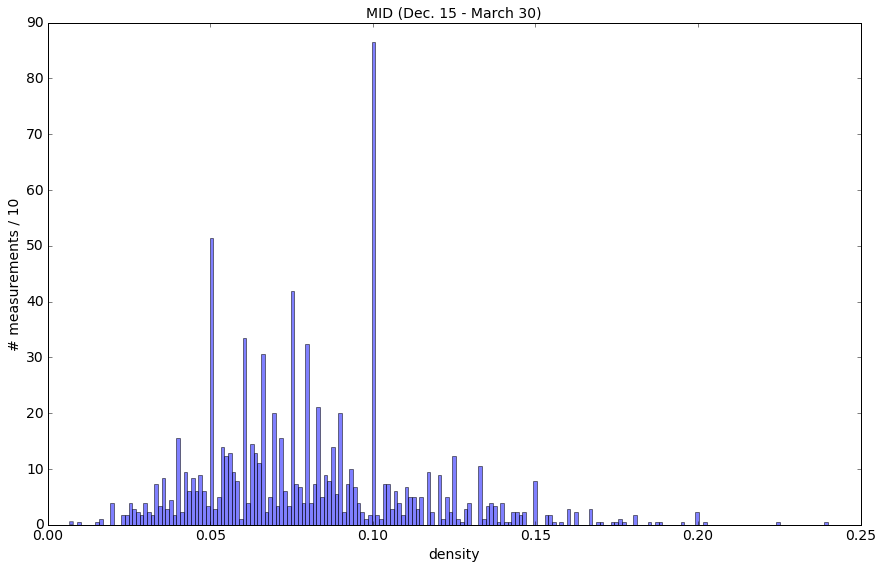

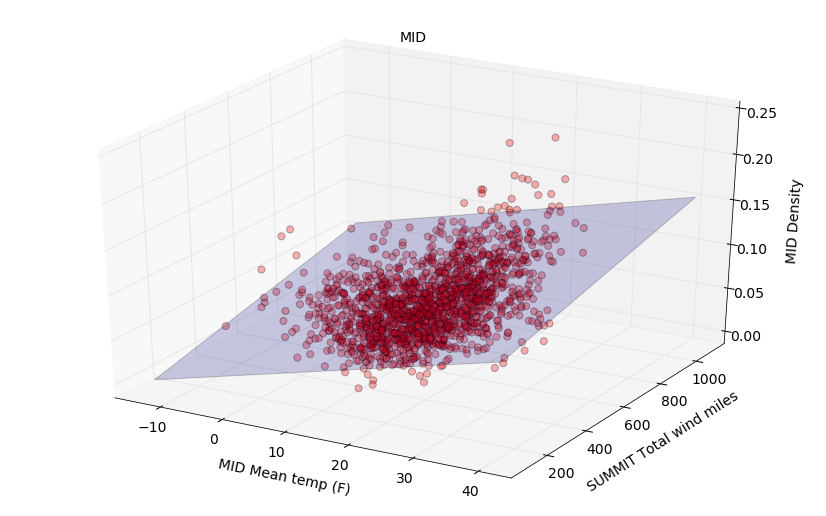

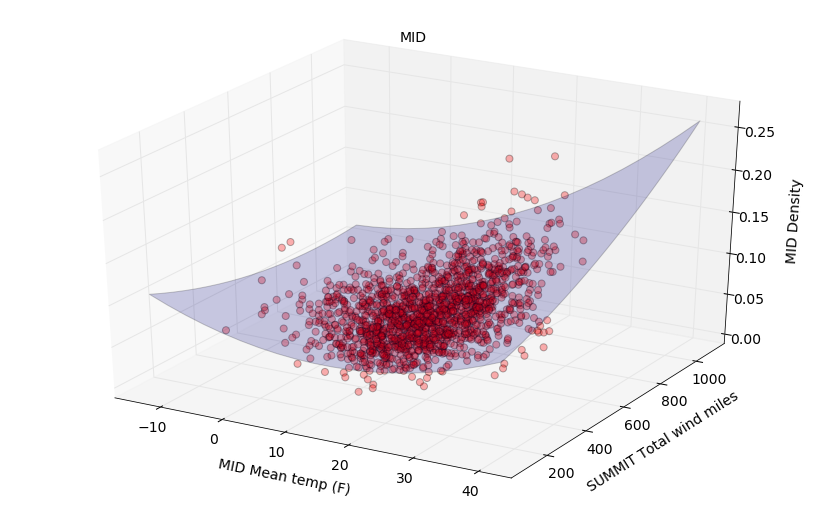

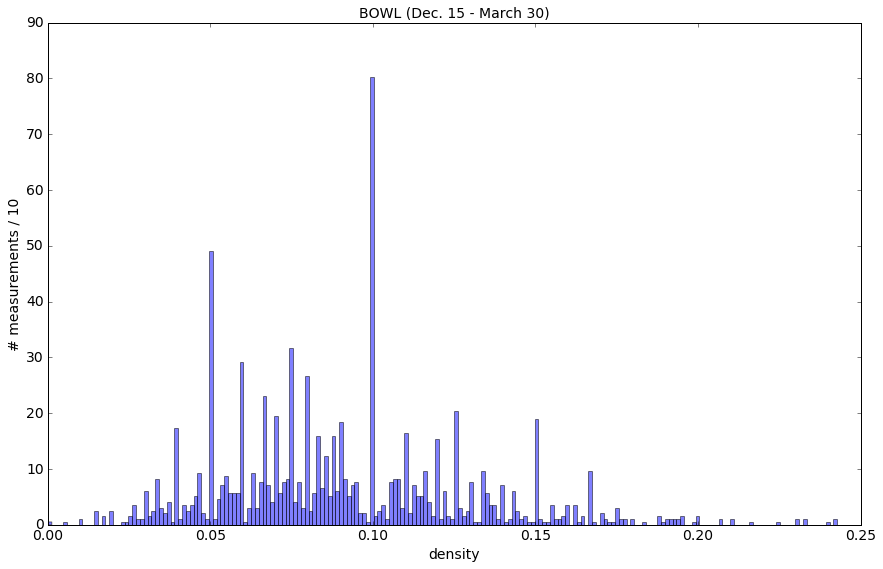

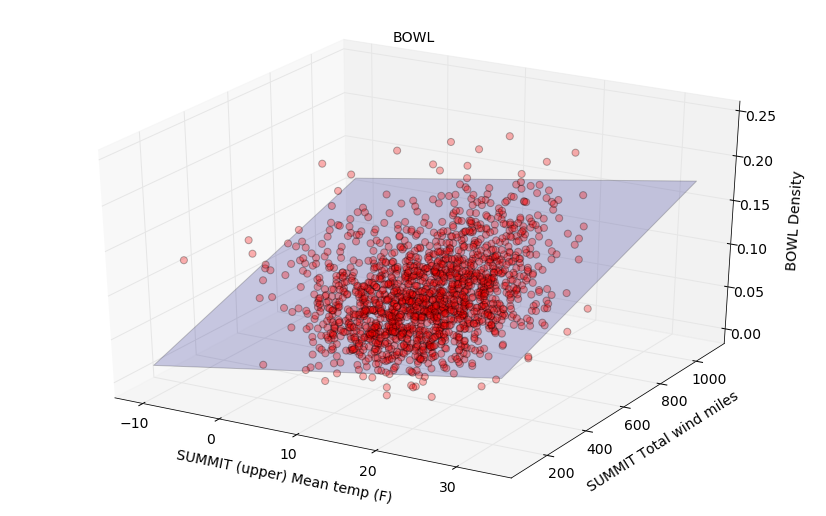

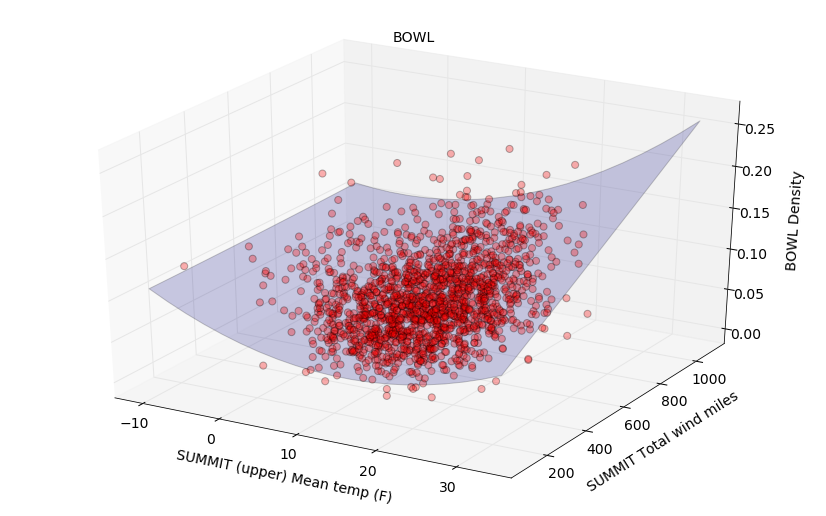

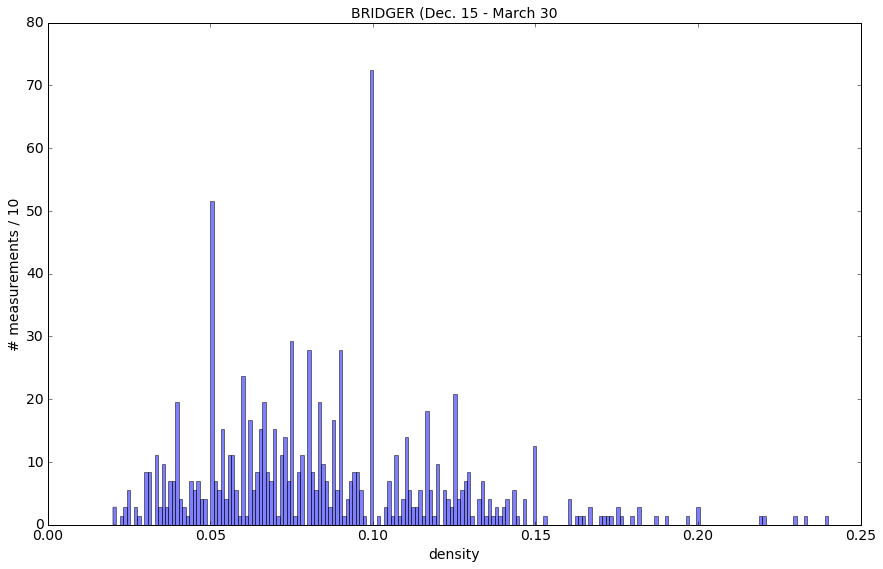

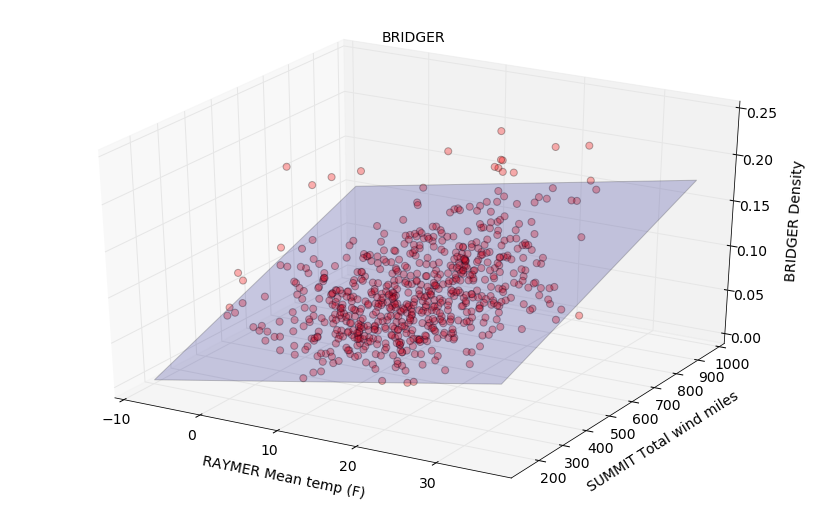

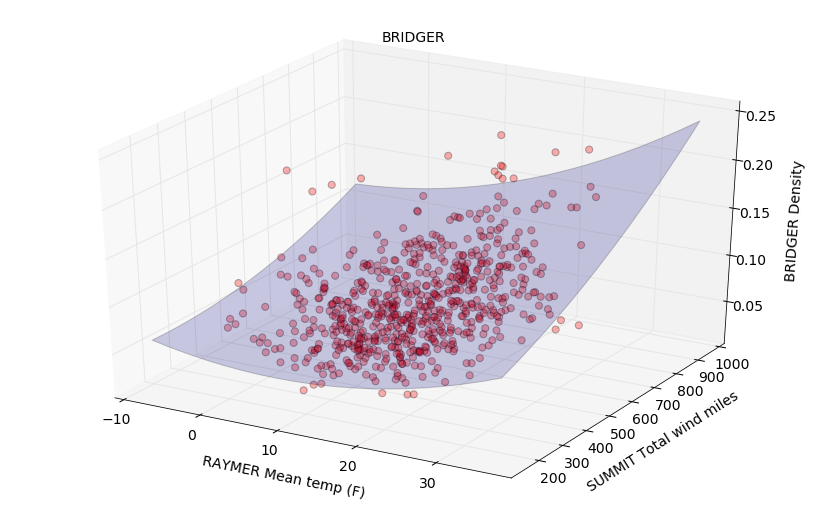

In [73]:
from mpl_toolkits.mplot3d import Axes3D
import scipy.linalg
from matplotlib import cm

# MID

x = temp_mean_mid[idx_mid.index]
y = total_miles_resample[idx_mid.index]
z = densityMid[idx_mid.index]

histoplot(z,'MID (Dec. 15 - March 30)')

d = {'temp': x, 'wind': y, 'dens': z}
df = pd.DataFrame(data=d)

x = df.temp
y = df.wind
z = df.dens

# Add best-fit 2D plane:

data = np.c_[x,y,z]

# regular grid covering the domain of the data
mn = np.min(data, axis=0)
mx = np.max(data, axis=0)
X,Y = np.meshgrid(np.linspace(mn[0], mx[0], 20), np.linspace(mn[1], mx[1], 20))
XX = X.flatten()
YY = Y.flatten()

order = 1    # 1: linear, 2: quadratic
if order == 1:
    # best-fit linear plane
    A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients
    
    # evaluate it on grid
    Z = C[0]*X + C[1]*Y + C[2]
    
    # or expressed using matrix/vector product
    #Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

elif order == 2:
    # best-fit quadratic curve
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)


# plot points and fitted surface
fig = plt.figure(figsize=(9 * 1.618, 9))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, rstride=50, cstride=50, alpha=0.2)
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=50, alpha=0.3)

#ax.scatter(35,1000,density_2, c='r', s=100)

plt.xlabel('MID Mean temp (F)', fontsize=14)
plt.ylabel('SUMMIT Total wind miles', fontsize=14)
ax.set_zlabel('MID Density', fontsize=14)
ax.set_title('MID', fontsize=14)
ax.axis('equal')
ax.axis('tight')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 15

order = 2    # 1: linear, 2: quadratic
if order == 1:
    # best-fit linear plane
    A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients
    
    # evaluate it on grid
    Z = C[0]*X + C[1]*Y + C[2]
    
    # or expressed using matrix/vector product
    #Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

elif order == 2:
    # best-fit quadratic curve
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)


def calc_dens_2(temp,wind):
  density = C[4]*temp**2. + C[5]*wind**2. + C[3]*temp*wind + C[1]*temp + C[2]*wind + C[0]
  return density

print ''
print '----------------------------------------------'
print 'MID 2nd-order coefficients:'
print C
print '----------------------------------------------'
print ''

density_2 = calc_dens_2(35,1000)

print ' '
print "-----------MID-----------"
est = smf.ols(formula='dens ~ 1 + I(temp ** 2.0) + I(wind ** 2.0) + I(temp * wind) + temp + wind', data=df).fit()
print est.summary()

# plot points and fitted surface
fig = plt.figure(figsize=(9 * 1.618, 9))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, rstride=50, cstride=50, alpha=0.2)
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=50, alpha=0.3)

#ax.scatter(35,1000,density_2, c='r', s=100)

plt.xlabel('MID Mean temp (F)', fontsize=14)
plt.ylabel('SUMMIT Total wind miles', fontsize=14)
ax.set_zlabel('MID Density', fontsize=14)
ax.set_title('MID', fontsize=14)
ax.axis('equal')
ax.axis('tight')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 15


#---------------------------------------------------------------------------------
# BOWL

x = temp_mean_Summit[idx_bowl.index]
y = total_miles_resample[idx_bowl.index]
z = densityBowl[idx_bowl.index]

histoplot(z,'BOWL (Dec. 15 - March 30)')

d = {'temp': x, 'wind': y, 'dens': z}
df = pd.DataFrame(data=d)

x = df.temp
y = df.wind
z = df.dens

# Add best-fit 2D plane:

data = np.c_[x,y,z]

# regular grid covering the domain of the data
mn = np.min(data, axis=0)
mx = np.max(data, axis=0)
X,Y = np.meshgrid(np.linspace(mn[0], mx[0], 20), np.linspace(mn[1], mx[1], 20))
XX = X.flatten()
YY = Y.flatten()

order = 1    # 1: linear, 2: quadratic
if order == 1:
    # best-fit linear plane
    A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients
    
    # evaluate it on grid
    Z = C[0]*X + C[1]*Y + C[2]
    
    # or expressed using matrix/vector product
    #Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

elif order == 2:
    # best-fit quadratic curve
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

# plot points and fitted surface
fig = plt.figure(figsize=(9 * 1.618, 9))
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, Z, rstride=50, cstride=50, alpha=0.2)
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=50, alpha=0.3)

plt.xlabel('SUMMIT (upper) Mean temp (F)', fontsize=14)
plt.ylabel('SUMMIT Total wind miles', fontsize=14)
ax.set_zlabel('BOWL Density', fontsize=14)
ax.set_title('BOWL', fontsize=14)
ax.axis('equal')
ax.axis('tight')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 15

order = 2    # 1: linear, 2: quadratic
if order == 1:
    # best-fit linear plane
    A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients
    
    # evaluate it on grid
    Z = C[0]*X + C[1]*Y + C[2]
    
    # or expressed using matrix/vector product
    #Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

elif order == 2:
    # best-fit quadratic curve
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

print ''
print '----------------------------------------------'
print 'BOWL 2nd-order coefficients:'
print C
print '----------------------------------------------'
print ''

print ' '
print "-----------BOWL-----------"
est = smf.ols(formula='dens ~ 1 + I(temp ** 2.0) + I(wind ** 2.0) + I(temp * wind) + temp + wind', data=df).fit()
print est.summary()

# plot points and fitted surface
fig = plt.figure(figsize=(9 * 1.618, 9))
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, Z, rstride=50, cstride=50, alpha=0.2)
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=50, alpha=0.3)

plt.xlabel('SUMMIT (upper) Mean temp (F)', fontsize=14)
plt.ylabel('SUMMIT Total wind miles', fontsize=14)
ax.set_zlabel('BOWL Density', fontsize=14)
ax.set_title('BOWL', fontsize=14)
ax.axis('equal')
ax.axis('tight')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 15

#---------------------------------------------------------------------------------
# BRIDGER

x = temp_mean_ray[idx_bridger.index]
y = total_miles_resample[idx_bridger.index]
z = densityBridger[idx_bridger.index]

d = {'temp': x, 'wind': y, 'dens': z}
df = pd.DataFrame(data=d)

x = df.temp
y = df.wind
z = df.dens

histoplot(z,'BRIDGER (Dec. 15 - March 30')

# Add best-fit 2D plane:

data = np.c_[x,y,z]

# regular grid covering the domain of the data
mn = np.min(data, axis=0)
mx = np.max(data, axis=0)
X,Y = np.meshgrid(np.linspace(mn[0], mx[0], 20), np.linspace(mn[1], mx[1], 20))
XX = X.flatten()
YY = Y.flatten()

order = 1    # 1: linear, 2: quadratic
if order == 1:
    # best-fit linear plane
    A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients
    
    # evaluate it on grid
    Z = C[0]*X + C[1]*Y + C[2]
    
    # or expressed using matrix/vector product
    #Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

elif order == 2:
    # best-fit quadratic curve
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

# plot points and fitted surface
fig = plt.figure(figsize=(9 * 1.618, 9))
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, Z, rstride=50, cstride=50, alpha=0.2)
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=50, alpha=0.3)

plt.xlabel('RAYMER Mean temp (F)', fontsize=14)
plt.ylabel('SUMMIT Total wind miles', fontsize=14)
ax.set_zlabel('BRIDGER Density', fontsize=14)
ax.set_title('BRIDGER', fontsize=14)
ax.axis('equal')
ax.axis('tight')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 15

order = 2    # 1: linear, 2: quadratic
if order == 1:
    # best-fit linear plane
    A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients
    
    # evaluate it on grid
    Z = C[0]*X + C[1]*Y + C[2]
    
    # or expressed using matrix/vector product
    #Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

elif order == 2:
    # best-fit quadratic curve
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)
    
print ''
print '----------------------------------------------'
print 'BRIDGER 2nd-order coefficients:'
print C
print '----------------------------------------------'
print ''

print ' '
print "-----------BRIDGER-----------"
est = smf.ols(formula='dens ~ 1 + I(temp ** 2.0) + I(wind ** 2.0) + I(temp * wind) + temp + wind', data=df).fit()
print est.summary()

# plot points and fitted surface
fig = plt.figure(figsize=(9 * 1.618, 9))
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, Z, rstride=50, cstride=50, alpha=0.2)
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=50, alpha=0.3)

plt.xlabel('RAYMER Mean temp (F)', fontsize=14)
plt.ylabel('SUMMIT Total wind miles', fontsize=14)
ax.set_zlabel('BRIDGER Density', fontsize=14)
ax.set_title('BRIDGER', fontsize=14)
ax.axis('equal')
ax.axis('tight')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 15

# 4. Equations

For all equations, x = air temp, y = wind speed, z = density

*General 2nd-order polynomial (quadratic) equation:*

z = C[0] + C[1] x + C[2] y + C[3] x y + C[4] x<sup>2</sup> + C[5] y<sup>2</sup>

*Coefficients:*

**Mid Mtn:**

C =

[8.35837592e-02 

-2.01517519e-03

-8.07055249e-05

3.60631948e-06

6.03187229e-05

7.27105870e-08]

**Rendezvous Bowl:**

C =

[6.55017414e-02

-3.30551280e-03

3.85180766e-05

3.81608580e-06

1.04816850e-04

3.70977314e-09]

**Raymer:**

C = 

[5.16207064e-02

-1.30771830e-03

-1.44523613e-05

2.62398826e-06

5.81504797e-05

9.31786756e-08]






# 5. Wind vs. density

In addition to the multiple OLS results above, the following plots show the relationship between wind and density. The relationship is not as strong as that between air temperature and density (summarized in Part I).

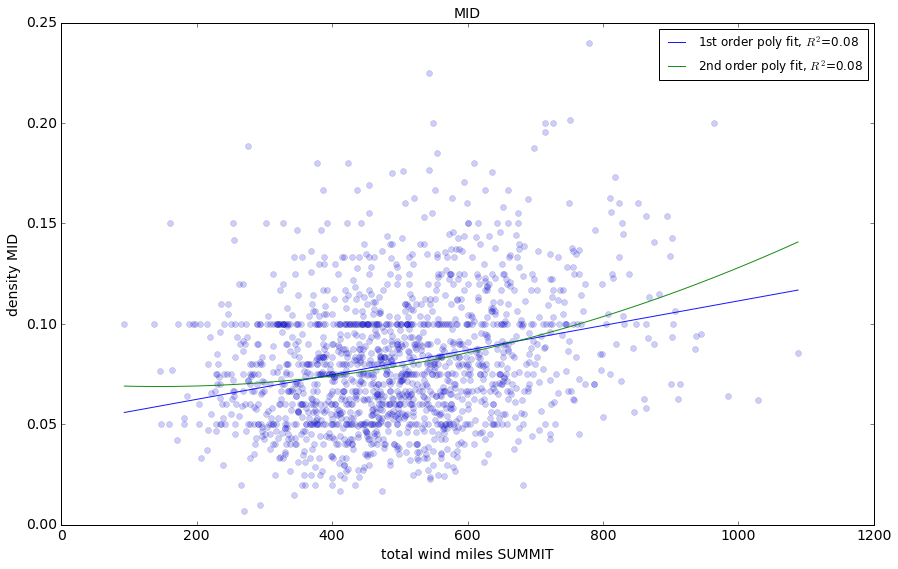

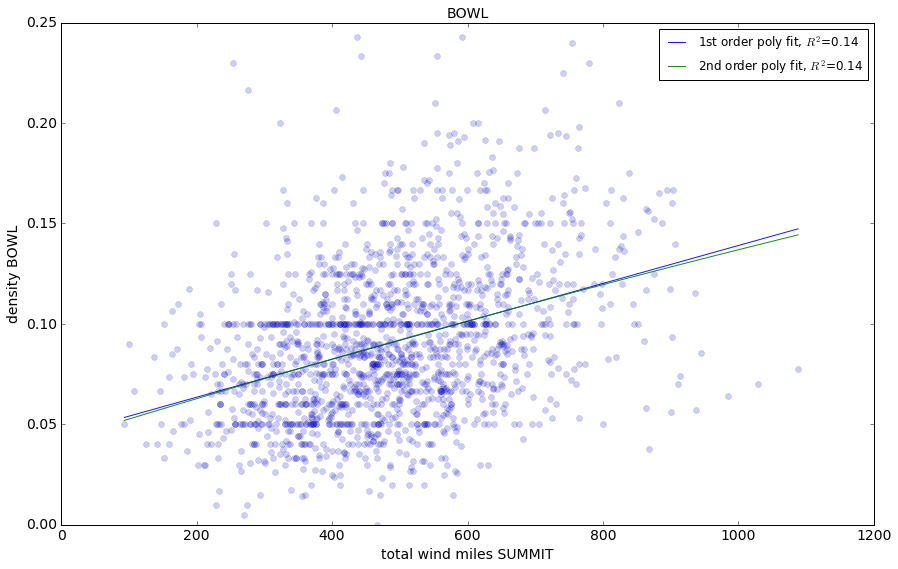

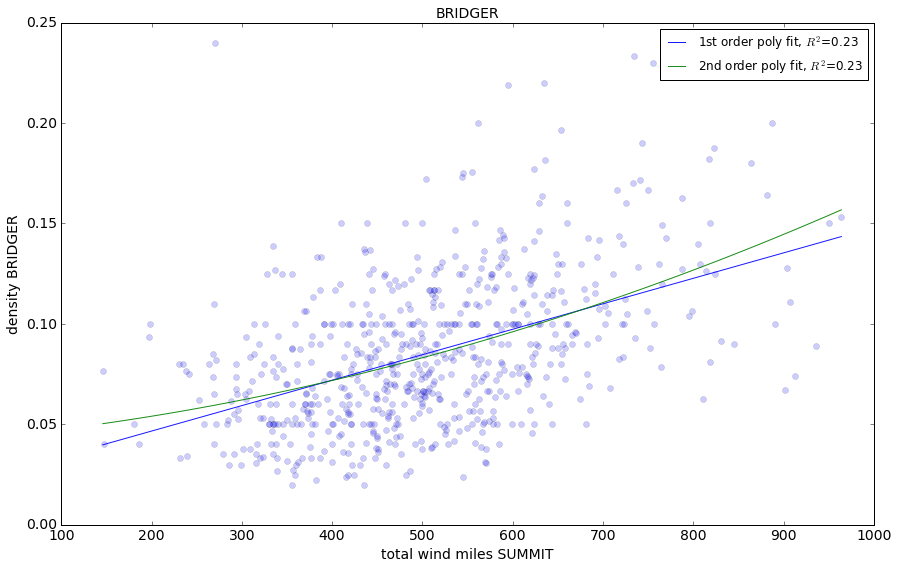

In [74]:
# MID wind vs. density:
x=total_miles_resample[idx_mid.index]
y=densityMid[idx_mid.index]

d = {'wind': x, 'dens': y}
df = pd.DataFrame(data=d)

plt.figure(figsize=(9 * 1.618, 9))
plt.plot(x,y, 'o', alpha=0.2)
plt.xlabel('total wind miles SUMMIT', fontsize=14)
plt.ylabel('density MID', fontsize=14)
plt.title('MID', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)

# points linearly spaced on temp
x1 = pd.DataFrame({'wind': np.linspace(df.wind.min(), df.wind.max(), 100)})

# 1st order polynomial
poly_1 = smf.ols(formula='dens ~ 1 + wind', data=df).fit()
plt.plot(x1.wind, poly_1.predict(x1), 'b-', label='1st order poly fit, $R^2$=%.2f' % poly_1.rsquared, 
         alpha=0.9)

# 2nd order polynomial
poly_2 = smf.ols(formula='dens ~ 1 + wind + I(wind ** 2.0)', data=df).fit()
plt.plot(x1.wind, poly_2.predict(x1), 'g-', label='2nd order poly fit, $R^2$=%.2f' % poly_2.rsquared, 
         alpha=0.9)

plt.legend()


# BOWL wind vs. density:
x=total_miles_resample[idx_bowl.index]
y=densityBowl[idx_bowl.index]

d = {'wind': x, 'dens': y}
df = pd.DataFrame(data=d)

plt.figure(figsize=(9 * 1.618, 9))
plt.plot(x,y, 'o', alpha=0.2)
plt.xlabel('total wind miles SUMMIT', fontsize=14)
plt.ylabel('density BOWL', fontsize=14)
plt.title('BOWL', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)

# points linearly spaced on temp
x1 = pd.DataFrame({'wind': np.linspace(df.wind.min(), df.wind.max(), 100)})

# 1st order polynomial
poly_1 = smf.ols(formula='dens ~ 1 + wind', data=df).fit()
plt.plot(x1.wind, poly_1.predict(x1), 'b-', label='1st order poly fit, $R^2$=%.2f' % poly_1.rsquared, 
         alpha=0.9)

# 2nd order polynomial
poly_2 = smf.ols(formula='dens ~ 1 + wind + I(wind ** 2.0)', data=df).fit()
plt.plot(x1.wind, poly_2.predict(x1), 'g-', label='2nd order poly fit, $R^2$=%.2f' % poly_2.rsquared, 
         alpha=0.9)

plt.legend()


# BRIDGER wind vs. density:
x=total_miles_resample[idx_bridger.index]
y=densityBridger[idx_bridger.index]

d = {'wind': x, 'dens': y}
df = pd.DataFrame(data=d)

plt.figure(figsize=(9 * 1.618, 9))
plt.plot(x,y, 'o', alpha=0.2)
plt.xlabel('total wind miles SUMMIT', fontsize=14)
plt.ylabel('density BRIDGER', fontsize=14)
plt.title('BRIDGER', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)

# points linearly spaced on temp
x1 = pd.DataFrame({'wind': np.linspace(df.wind.min(), df.wind.max(), 100)})

# 1st order polynomial
poly_1 = smf.ols(formula='dens ~ 1 + wind', data=df).fit()
plt.plot(x1.wind, poly_1.predict(x1), 'b-', label='1st order poly fit, $R^2$=%.2f' % poly_1.rsquared, 
         alpha=0.9)

# 2nd order polynomial
poly_2 = smf.ols(formula='dens ~ 1 + wind + I(wind ** 2.0)', data=df).fit()
plt.plot(x1.wind, poly_2.predict(x1), 'g-', label='2nd order poly fit, $R^2$=%.2f' % poly_2.rsquared, 
         alpha=0.9)

plt.legend()
